# Task 4: Proxy Target Variable Engineering
## Creating High-Risk Customer Labels using RFM Analysis

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration
RAW_DATA_PATH = "../data/raw/data.csv"  # Source data with customer IDs
PROCESSED_DATA_PATH = "../data/processed/model_features.csv"  # From Task 3
OUTPUT_PATH = "../data/processed/model_features_with_target.csv"

## 1. Load and Verify Data
We need both raw and processed data to:
- Calculate RFM from raw transactions (customer-level)
- Merge labels with processed features

In [8]:
# Load raw data (for RFM calculation)
try:
    raw_df = pd.read_csv(RAW_DATA_PATH, parse_dates=['TransactionStartTime'])
    raw_df.columns = raw_df.columns.str.lower()  # Standardize column names
    print("Raw data loaded. Columns:", raw_df.columns.tolist())
except Exception as e:
    print(f"Error loading raw data: {str(e)}")

# Load processed features (from Task 3)
try:
    processed_df = pd.read_csv(PROCESSED_DATA_PATH)
    print("\nProcessed data loaded. Columns:", processed_df.columns.tolist())
    
    # Check for customer ID
    if 'customerid' not in processed_df.columns:
        print("\nCRITICAL: customerid missing in processed data!")
        print("Please reprocess data with Task 3 fixes before continuing.")
except Exception as e:
    print(f"\nError loading processed data: {str(e)}")

Raw data loaded. Columns: ['transactionid', 'batchid', 'accountid', 'subscriptionid', 'customerid', 'currencycode', 'countrycode', 'providerid', 'productid', 'productcategory', 'channelid', 'amount', 'value', 'transactionstarttime', 'pricingstrategy', 'fraudresult']

Error loading processed data: [Errno 2] No such file or directory: '../data/processed/model_features.csv'


## 2. Cluster Transactions Using RFM Features

In [3]:
# Scale features (even though they're already normalized)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Cluster into 3 segments
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Add clusters back to DataFrame
processed_df['cluster'] = clusters

## 3. Identify High-Risk Cluster

In [4]:
# Calculate cluster characteristics
cluster_stats = processed_df.groupby('cluster').agg({
    'num__recency': 'mean',
    'num__frequency': 'mean',
    'num__monetary': 'mean'
}).sort_values(
    ['num__recency', 'num__frequency', 'num__monetary'],
    ascending=[False, True, True]  # High recency = bad, low frequency/monetary = bad
)

# Identify high-risk cluster
high_risk_cluster = cluster_stats.index[0]
processed_df['is_high_risk'] = (processed_df['cluster'] == high_risk_cluster).astype(int)

print("Cluster Statistics:")
display(cluster_stats)

Cluster Statistics:


,num__recency,num__frequency,num__monetary
cluster,,,
2,1.8031,-0.3499,0.1147
1,0.7940,3.4381,0.0881
0,-0.4797,-0.2115,-0.0337


## 4. Visualize Clusters

<Figure size 1200x800 with 0 Axes>

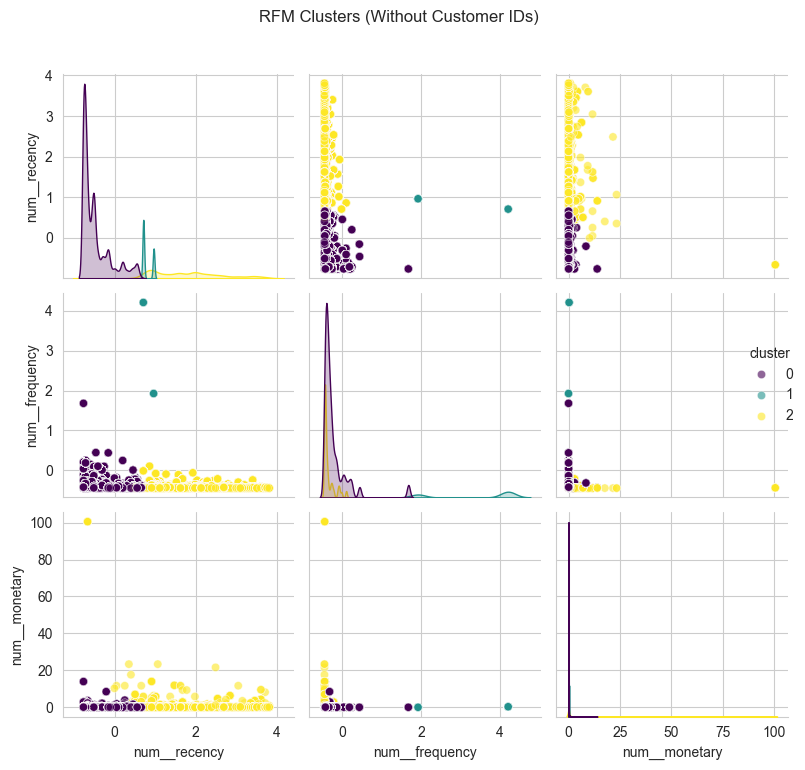

In [5]:
# Pairplot of RFM features
plt.figure(figsize=(12, 8))
sns.pairplot(
    processed_df,
    vars=['num__recency', 'num__frequency', 'num__monetary'],
    hue='cluster',
    palette='viridis',
    plot_kws={'alpha': 0.6}
)
plt.suptitle('RFM Clusters (Without Customer IDs)', y=1.02)
plt.tight_layout()
plt.show()

## 5. Analyze Target Distribution

In [10]:
# Target distribution
target_dist = processed_df['is_high_risk'].value_counts(normalize=True)
print("\nProxy Target Distribution:")
print(f"Low Risk (0): {target_dist.get(0, 0):.2%}")
print(f"High Risk (1): {target_dist.get(1, 0):.2%}")

# Show high-risk characteristics
high_risk_stats = cluster_stats.loc[high_risk_cluster]
print("\nHigh Risk Cluster Characteristics:")
print(f"- Recency (normalized): {high_risk_stats['num__recency']:.2f}")
print(f"- Frequency (normalized): {high_risk_stats['num__frequency']:.2f}")
print(f"- Monetary (normalized): {high_risk_stats['num__monetary']:.2f}")


Proxy Target Distribution:
Low Risk (0): 83.11%
High Risk (1): 16.89%

High Risk Cluster Characteristics:
- Recency (normalized): 1.84
- Frequency (normalized): -0.36
- Monetary (normalized): 0.12


## 6. Save Results

In [11]:
# Save enriched data
output_path = "../data/processed/model_features_with_target.csv"
processed_df.to_csv(output_path, index=False)
print(f"Saved results to {output_path}")

# Save cluster stats
stats_path = "../data/processed/cluster_statistics.csv"
cluster_stats.to_csv(stats_path)
print(f"Saved cluster statistics to {stats_path}")

Saved results to ../data/processed/model_features_with_target.csv
Saved cluster statistics to ../data/processed/cluster_statistics.csv
